# **Health Insurance Lead Prediction**

Your Client FinMan is a financial services company that provides various 

financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

Now the company needs your help in building a model to predict whether the person will be interested in their proposed Health plan/policy given the information about:



> Demographics (city, age, region etc.)

> Information regarding holding policies of the customer

> Recommended Policy Information















# **Data Dictionary**

**Train Data**

![picture](https://drive.google.com/file/d/1nOAJrHnJBteW8fteUYP4kg2V5Cb7Ztch/view?usp=sharing)


**Test Data**

![picture](https://drive.google.com/file/d/1QXp2ds_mp8g93fCk8Bf2srJEMqro-sLz/view?usp=sharing)

**Sample Submission**

This file contains the exact submission format for the predictions. Please submit CSV file only.

![picture](https://drive.google.com/file/d/1RHfQCoRbhoCAuQIk2qzOZvHrXieKabGe/view?usp=sharing)

## **Evaluation**

The evaluation metric for this competition is roc_auc_score across all entries in the test set.

In [1]:
# Authenticate Google colab to import files from drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Upload the files from local here .rar format or .zip format -clean.rar
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving sample_submission_QrCyCoT.csv to sample_submission_QrCyCoT.csv
Saving test_YCcRUnU.csv to test_YCcRUnU.csv
Saving train_Df64byy.csv to train_Df64byy.csv
User uploaded file "sample_submission_QrCyCoT.csv" with length 174452 bytes
User uploaded file "test_YCcRUnU.csv" with length 1268506 bytes
User uploaded file "train_Df64byy.csv" with length 3049673 bytes


In [3]:
# import standard libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

In [4]:
# import all the related libraries

from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,cross_val_score,cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV,KFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [5]:
!pip install catboost

     |████████████████████████████████| 65.7MB 64kB/s 


In [6]:
from catboost import CatBoostClassifier

In [364]:
# Read the data files - Training, Test and Submition sample  data

train = pd.read_csv('/content/train_Df64byy.csv')

test  = pd.read_csv('/content/test_YCcRUnU.csv')

subm = pd.read_csv('/content/sample_submission_QrCyCoT.csv')


In [365]:
train.shape,test.shape,subm.shape

((50882, 14), (21805, 13), (21805, 2))

In [366]:
# Train details

train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [334]:
train[train.Response==1]['Accomodation_Type'].value_counts(),train[train.Response==0]['Accomodation_Type'].value_counts()

(Owned     6763
 Rented    5446
 Name: Accomodation_Type, dtype: int64, Owned     21188
 Rented    17485
 Name: Accomodation_Type, dtype: int64)

In [337]:
train[train.Response==1]['Reco_Insurance_Type'].value_counts(),train[train.Response==0]['Reco_Insurance_Type'].value_counts()

(Individual    9640
 Joint         2569
 Name: Reco_Insurance_Type, dtype: int64, Individual    30896
 Joint          7777
 Name: Reco_Insurance_Type, dtype: int64)

In [339]:
_IO = 6763 / (6763+ 5446) * ( 9640 / (9640+2569)) # Individual Owned who opted for Insurance

_IR = 5446 / (6763+ 5446) * ( 9640 / (9640+2569)) # Individual Rented who opted for Insurance

_JO = 6763 / (6763+ 5446) * ( 2569 / (9640+2569)) # Joint and Owned who opted for Insurance

_JR =  5446 / (6763+ 5446) * ( 2569 / (9640+2569)) # Joint and Rented who opted for Insurance

_IO,_IR,_IO,_IR


(0.43737729453479773,
 0.3522041617679297,
 0.43737729453479773,
 0.3522041617679297)

In [273]:
train.dtypes  # check the data types categorical and continuous variables

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
dtype: object

In [274]:
train.isnull().sum() / train.shape[0]  # % of NAN in the data

ID                         0.000000
City_Code                  0.000000
Region_Code                0.000000
Accomodation_Type          0.000000
Reco_Insurance_Type        0.000000
Upper_Age                  0.000000
Lower_Age                  0.000000
Is_Spouse                  0.000000
Health Indicator           0.229767
Holding_Policy_Duration    0.397999
Holding_Policy_Type        0.397999
Reco_Policy_Cat            0.000000
Reco_Policy_Premium        0.000000
Response                   0.000000
dtype: float64

In [275]:
train[train['Holding_Policy_Duration'].isna()]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
6,7,C3,679,Owned,Individual,28,28,No,NaN,NaN,NaN,17,10640.0,0
10,11,C28,600,Owned,Individual,21,21,No,X2,NaN,NaN,21,4068.0,1
13,14,C5,900,Rented,Individual,20,20,No,X2,NaN,NaN,18,8364.0,0
15,16,C3,1484,Rented,Individual,20,20,No,X3,NaN,NaN,2,4912.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50863,50864,C1,3705,Owned,Individual,75,75,No,X3,NaN,NaN,16,17850.0,1
50864,50865,C27,3469,Owned,Individual,72,72,No,X4,NaN,NaN,2,17312.0,0
50865,50866,C21,4915,Owned,Individual,74,74,No,NaN,NaN,NaN,14,19944.0,0
50867,50868,C6,2040,Owned,Individual,37,37,No,X2,NaN,NaN,20,10016.0,0


In [276]:
train[train['Response'] == 1]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
5,6,C9,1785,Rented,Individual,52,52,No,X2,5.0,1.0,22,15264.0,1
7,8,C1,3175,Owned,Joint,75,73,Yes,X4,9.0,4.0,17,29344.0,1
9,10,C1,530,Owned,Joint,59,26,Yes,NaN,7.0,4.0,18,21100.8,1
10,11,C28,600,Owned,Individual,21,21,No,X2,NaN,NaN,21,4068.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50858,50859,C1,494,Rented,Joint,62,29,Yes,X1,13.0,3.0,18,24323.2,1
50863,50864,C1,3705,Owned,Individual,75,75,No,X3,NaN,NaN,16,17850.0,1
50868,50869,C1,2327,Owned,Individual,75,75,No,X3,9.0,3.0,18,22066.0,1
50875,50876,C6,231,Rented,Individual,36,36,No,X3,2.0,1.0,20,13574.0,1


In [277]:
train[train['Response'] == 0]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0
6,7,C3,679,Owned,Individual,28,28,No,NaN,NaN,NaN,17,10640.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50876,50877,C26,579,Owned,Individual,37,37,No,NaN,2.0,1.0,12,13222.0,0
50877,50878,C4,845,Rented,Individual,22,22,No,X3,NaN,NaN,18,7704.0,0
50878,50879,C5,4188,Rented,Individual,27,27,No,X3,7.0,3.0,4,5408.0,0
50879,50880,C1,442,Rented,Individual,63,63,No,X2,14+,1.0,12,11374.0,0


In [278]:
train['Reco_Policy_Premium'].min(),train['Reco_Policy_Premium'].max()

(2280.0, 43350.4)

In [279]:
train[train.Response == 1]['Reco_Policy_Premium'].min(),train[train.Response == 1]['Reco_Policy_Premium'].max()

(2408.0, 42316.8)

In [280]:
test.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
dtype: object

In [281]:
test.isnull().sum() / test.shape[0]

ID                         0.000000
City_Code                  0.000000
Region_Code                0.000000
Accomodation_Type          0.000000
Reco_Insurance_Type        0.000000
Upper_Age                  0.000000
Lower_Age                  0.000000
Is_Spouse                  0.000000
Health Indicator           0.230543
Holding_Policy_Duration    0.394543
Holding_Policy_Type        0.394543
Reco_Policy_Cat            0.000000
Reco_Policy_Premium        0.000000
dtype: float64

In [282]:
# exploration of train data set

train.City_Code.nunique(),train.Region_Code.nunique(),train.Accomodation_Type .nunique(),train.Reco_Insurance_Type.nunique()

(36, 5316, 2, 2)

In [283]:
train['Health Indicator'].unique()

array(['X1', 'X2', nan, 'X4', 'X3', 'X6', 'X5', 'X8', 'X7', 'X9'],
      dtype=object)

In [284]:
train['Holding_Policy_Duration'].unique()

array(['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
       '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

In [285]:
train['Reco_Policy_Cat'].unique()

array([22, 19, 16, 17,  1, 18, 21, 13, 20,  9,  2,  4, 12,  6, 14, 11,  3,
        8,  7, 10, 15,  5])

In [367]:
new_data = { "14+":"15","1.0":"1","2.0":"2","3.0":"3","4.0":"4","5.0":"5",
             "6.0":"6","7.0":"7","8.0":"8","9.0" :"9","10.0":"10","11.0":"11",
             "12.0":"12","13.0":"13","14.0":"14" } 
  
# combine this new data with existing DataFrame 
train["Holding_Policy_Duration_YRS"] = (train["Holding_Policy_Duration"].map(new_data))
train['Holding_Policy_Duration_YRS'] = train['Holding_Policy_Duration_YRS'].fillna('20')
train['Holding_Policy_Duration_YRS'] = train['Holding_Policy_Duration_YRS'].astype(int)

test["Holding_Policy_Duration_YRS"] = (test["Holding_Policy_Duration"].map(new_data))
test['Holding_Policy_Duration_YRS'] = test['Holding_Policy_Duration_YRS'].fillna('20')
test['Holding_Policy_Duration_YRS'] = test['Holding_Policy_Duration_YRS'].astype(int)

In [104]:
train.dtypes

ID                               int64
City_Code                       object
Region_Code                      int64
Accomodation_Type               object
Reco_Insurance_Type             object
Upper_Age                        int64
Lower_Age                        int64
Is_Spouse                       object
Health Indicator                object
Holding_Policy_Duration         object
Holding_Policy_Type            float64
Reco_Policy_Cat                  int64
Reco_Policy_Premium            float64
Response                         int64
Holding_Policy_Duration_YRS      int64
dtype: object

In [158]:
train['Holding_Policy_Type'].unique()

array([ 3., nan,  1.,  4.,  2.])

In [159]:
test['Health Indicator'].unique()

array([nan, 'X1', 'X3', 'X2', 'X5', 'X4', 'X7', 'X6', 'X9', 'X8'],
      dtype=object)

In [160]:
test['Holding_Policy_Duration'].unique()

array(['6.0', '3.0', '2.0', nan, '14+', '5.0', '1.0', '4.0', '12.0',
       '11.0', '7.0', '9.0', '13.0', '8.0', '14.0', '10.0'], dtype=object)

In [161]:
test['Holding_Policy_Type'].unique()

array([ 3.,  4., nan,  1.,  2.])

## Some Bssic Exploratory Data Ananlysis and plots

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


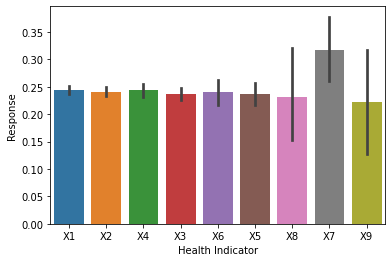

In [ ]:
sns.barplot(train['Health Indicator'],train['Response'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


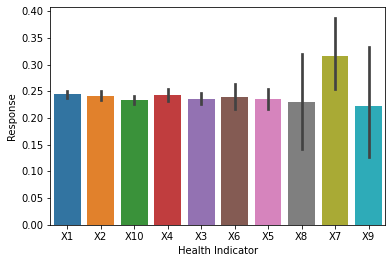

In [368]:
# impute new category X10 for all the missing values of Health Indicator
train['Health Indicator'] = train['Health Indicator'].fillna('X10')
sns.barplot(train['Health Indicator'],train['Response'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


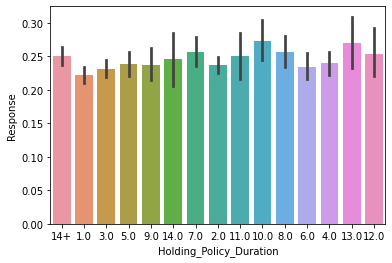

In [ ]:
sns.barplot(train['Holding_Policy_Duration'],train['Response'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


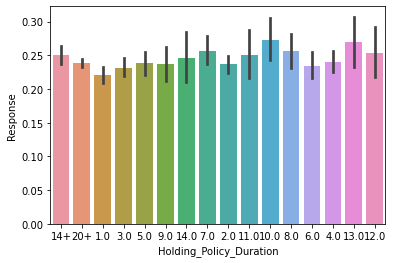

In [369]:
# impute new category X10 for all the missing values of Health Indicator
train['Holding_Policy_Duration'] = train['Holding_Policy_Duration'].fillna('20+')
sns.barplot(train['Holding_Policy_Duration'],train['Response'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


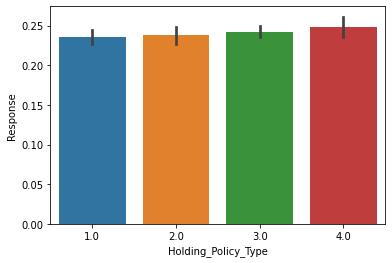

In [ ]:
sns.barplot(train['Holding_Policy_Type'],train['Response'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


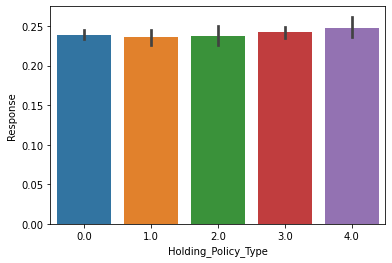

In [370]:
# impute new category X10 for all the missing values of Health Indicator
train['Holding_Policy_Type'] = train['Holding_Policy_Type'].fillna(0)
sns.barplot(train['Holding_Policy_Type'],train['Response'])

In [ ]:
# Label encoding the categorical columns

le = LabelEncoder()

train['City_Code']                 = le.fit_transform(train['City_Code'])
train['Accomodation_Type']         = le.fit_transform(train['Accomodation_Type'])
train['Reco_Insurance_Type']       = le.fit_transform(train['Reco_Insurance_Type'])
train['Is_Spouse']                 = le.fit_transform(train['Is_Spouse'])
train['Health Indicator']          = le.fit_transform(train['Health Indicator'])
#train['Holding_Policy_Duration']   = le.fit_transform(train['Holding_Policy_Duration'])

train.head()


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Holding_Policy_Duration_YRS
0,1,22,3213,1,0,36,36,0,0,14+,3.0,22,11628.0,0,15
1,2,31,1117,0,1,75,22,0,2,NaN,0.0,22,30510.0,0,20
2,3,31,3732,0,0,32,32,0,1,1.0,1.0,19,7450.0,1,1
3,4,16,4378,0,1,52,48,0,0,14+,3.0,19,17780.0,0,15
4,5,34,2190,1,0,44,44,0,2,3.0,1.0,16,10404.0,0,3


In [ ]:
#train = train.drop(columns=['Holding_Policy_Duration'])

In [165]:
train['Holding_Policy_Duration'].unique()

array(['14+', '20+', '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
       '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

In [166]:
train['Holding_Policy_Type'].unique()

array([3., 0., 1., 4., 2.])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


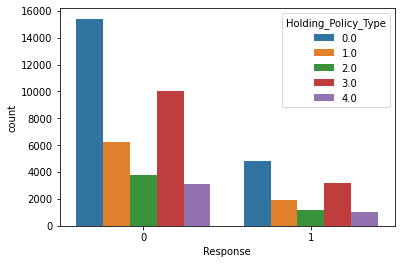

In [ ]:
sns.countplot(train.Response,hue=train.Holding_Policy_Type)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


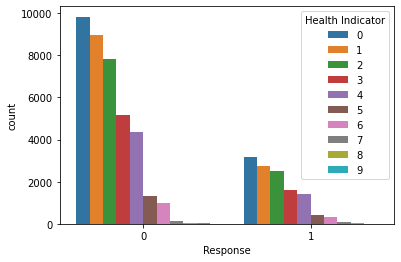

In [ ]:
sns.countplot(train.Response,hue=train['Health Indicator'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


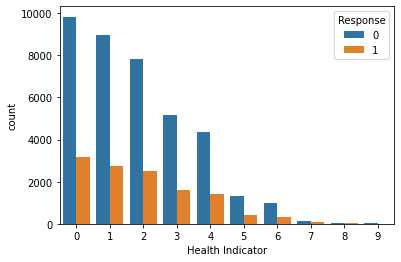

In [ ]:
sns.countplot(train['Health Indicator'],hue=train.Response)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


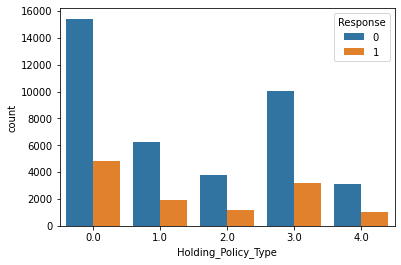

In [ ]:
sns.countplot(train.Holding_Policy_Type,hue=train.Response)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


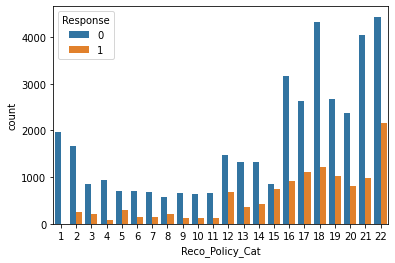

In [ ]:
sns.countplot(train['Reco_Policy_Cat'],hue=train.Response)

In [290]:
train.groupby('Response').count()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Holding_Policy_Duration_YRS
Response,,,,,,,,,,,,,,
0,38673,38673,38673,38673,38673,38673,38673,38673,38673,38673,38673,38673,38673,38673
1,12209,12209,12209,12209,12209,12209,12209,12209,12209,12209,12209,12209,12209,12209


In [371]:
# Total number of cases  of Premium availed by the policy holders in  ( city wise) TRAIN

dfcr = train[['City_Code','Region_Code','Reco_Policy_Premium']]
dfcr_0 = dfcr.groupby(['City_Code','Region_Code']).count()
dfcr_0

Reco_Policy_Premium
City_Code Region_Code                     
C1        4                             73
          5                             75
          6                             73
          8                             64
          15                            54
...                                    ...
C9        5891                           1
          5909                           1
          5922                           1
          6092                           1
          6123                           1

[5316 rows x 1 columns]

In [372]:
# Total number of cases  of Premium availed by the policy holders in  ( city wise) TEST

dfcrT = test[['City_Code','Region_Code','Reco_Policy_Premium']]
dfcrT_0 = dfcrT.groupby(['City_Code','Region_Code']).count()

In [373]:
dfcr_0

Reco_Policy_Premium
City_Code Region_Code                     
C1        4                             73
          5                             75
          6                             73
          8                             64
          15                            54
...                                    ...
C9        5891                           1
          5909                           1
          5922                           1
          6092                           1
          6123                           1

[5316 rows x 1 columns]

In [374]:
dfcrT_0

Reco_Policy_Premium
City_Code Region_Code                     
C1        4                             29
          5                             30
          6                             29
          8                             28
          15                            26
...                                    ...
C9        5477                           1
          5587                           1
          6078                           1
          6084                           1
          6089                           1

[4694 rows x 1 columns]

In [ ]:
try:
    x = dfcr_1.loc[6,3497]
    print(int(x.values))
except KeyError:
    x = 0
    print(x)


0


In [375]:
def _optedPolicy(row) :
  try:
    x = dfcr_0.loc[row.City_Code,row.Region_Code].values
    return(int(x))
  except KeyError:
    x = 0
    return x

def _optedPolicyT(row) :
  try:
    x = dfcrT_0.loc[row.City_Code,row.Region_Code].values
    return(int(x))
  except KeyError:
    x = 0
    return x
 

In [376]:
train['Total_Policy_Cases'] = train[['City_Code','Region_Code']].apply(lambda row : _optedPolicy(row),axis=1)  # No of cases who opted for policy from this city /region

In [377]:
test['Total_Policy_Cases'] = test[['City_Code','Region_Code']].apply(lambda row : _optedPolicyT(row),axis=1)   # No of cases who did not opt for policy from this city /region

In [298]:
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Holding_Policy_Duration_YRS,Total_Policy_Cases
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0,15,8
1,2,C5,1117,Owned,Joint,75,22,No,X2,20+,0.0,22,30510.0,0,20,17
2,3,C5,3732,Owned,Individual,32,32,No,X10,1.0,1.0,19,7450.0,1,1,7
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0,15,5
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0,3,11


In [378]:
# New Feature Engineering

# Insurance coverge period in years = UpperAge - LowerAge

train['Insurance_Cover_yrs'] = (train['Upper_Age'] - train['Lower_Age']) +1
test['Insurance_Cover_yrs']  = (test['Upper_Age']  - test['Lower_Age']) +1



In [379]:
# Total Insurance Amount Payable 

train['Total_Insurance_Payable'] = (train['Holding_Policy_Duration_YRS'] * train['Reco_Policy_Premium']) 
test['Total_Insurance_Payable']  = (test['Holding_Policy_Duration_YRS'] * test['Reco_Policy_Premium']) 

# Total Insurance Amount Fraction 
train['Total_Insurance_Payable_FR'] = train['Reco_Policy_Premium'] / train['Holding_Policy_Duration_YRS']
test['Total_Insurance_Payable_FR']  = test['Reco_Policy_Premium'] / test['Holding_Policy_Duration_YRS']


In [380]:
train = pd.get_dummies(train)  # One Hot Encoding of Categorical variables

In [381]:
train.shape

(50882, 81)

In [303]:
train.head()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Holding_Policy_Duration_YRS,Total_Policy_Cases,Insurance_Cover_yrs,Total_Insurance_Payable,Total_Insurance_Payable_FR,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,...,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Accomodation_Type_Owned,Accomodation_Type_Rented,Reco_Insurance_Type_Individual,Reco_Insurance_Type_Joint,Is_Spouse_No,Is_Spouse_Yes,Health Indicator_X1,Health Indicator_X10,Health Indicator_X2,Health Indicator_X3,Health Indicator_X4,Health Indicator_X5,Health Indicator_X6,Health Indicator_X7,Health Indicator_X8,Health Indicator_X9,Holding_Policy_Duration_1.0,Holding_Policy_Duration_10.0,Holding_Policy_Duration_11.0,Holding_Policy_Duration_12.0,Holding_Policy_Duration_13.0,Holding_Policy_Duration_14+,Holding_Policy_Duration_14.0,Holding_Policy_Duration_2.0,Holding_Policy_Duration_20+,Holding_Policy_Duration_3.0,Holding_Policy_Duration_4.0,Holding_Policy_Duration_5.0,Holding_Policy_Duration_6.0,Holding_Policy_Duration_7.0,Holding_Policy_Duration_8.0,Holding_Policy_Duration_9.0
0,1,3213,36,36,3.0,22,11628.0,0,15,8,1,174420.0,775.200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,1117,75,22,0.0,22,30510.0,0,20,17,54,610200.0,1525.500000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,3,3732,32,32,1.0,19,7450.0,1,1,7,1,7450.0,7450.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,4378,52,48,3.0,19,17780.0,0,15,5,5,266700.0,1185.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,2190,44,44,1.0,16,10404.0,0,3,11,1,31212.0,3468.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [304]:
train[train.Response ==0]

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Holding_Policy_Duration_YRS,Total_Policy_Cases,Insurance_Cover_yrs,Total_Insurance_Payable,Total_Insurance_Payable_FR,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,...,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Accomodation_Type_Owned,Accomodation_Type_Rented,Reco_Insurance_Type_Individual,Reco_Insurance_Type_Joint,Is_Spouse_No,Is_Spouse_Yes,Health Indicator_X1,Health Indicator_X10,Health Indicator_X2,Health Indicator_X3,Health Indicator_X4,Health Indicator_X5,Health Indicator_X6,Health Indicator_X7,Health Indicator_X8,Health Indicator_X9,Holding_Policy_Duration_1.0,Holding_Policy_Duration_10.0,Holding_Policy_Duration_11.0,Holding_Policy_Duration_12.0,Holding_Policy_Duration_13.0,Holding_Policy_Duration_14+,Holding_Policy_Duration_14.0,Holding_Policy_Duration_2.0,Holding_Policy_Duration_20+,Holding_Policy_Duration_3.0,Holding_Policy_Duration_4.0,Holding_Policy_Duration_5.0,Holding_Policy_Duration_6.0,Holding_Policy_Duration_7.0,Holding_Policy_Duration_8.0,Holding_Policy_Duration_9.0
0,1,3213,36,36,3.0,22,11628.0,0,15,8,1,174420.0,775.200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,1117,75,22,0.0,22,30510.0,0,20,17,54,610200.0,1525.500000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,4,4378,52,48,3.0,19,17780.0,0,15,5,5,266700.0,1185.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,2190,44,44,1.0,16,10404.0,0,3,11,1,31212.0,3468.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,7,679,28,28,0.0,17,10640.0,0,20,16,1,212800.0,532.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50876,50877,579,37,37,1.0,12,13222.0,0,2,19,1,26444.0,6611.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
50877,50878,845,22,22,0.0,18,7704.0,0,20,18,1,154080.0,385.200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
50878,50879,4188,27,27,3.0,4,5408.0,0,7,6,1,37856.0,772.571429,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
50879,50880,442,63,63,1.0,12,11374.0,0,15,20,1,170610.0,758.266667,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [305]:
train[train.Response ==1]

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Holding_Policy_Duration_YRS,Total_Policy_Cases,Insurance_Cover_yrs,Total_Insurance_Payable,Total_Insurance_Payable_FR,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,...,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Accomodation_Type_Owned,Accomodation_Type_Rented,Reco_Insurance_Type_Individual,Reco_Insurance_Type_Joint,Is_Spouse_No,Is_Spouse_Yes,Health Indicator_X1,Health Indicator_X10,Health Indicator_X2,Health Indicator_X3,Health Indicator_X4,Health Indicator_X5,Health Indicator_X6,Health Indicator_X7,Health Indicator_X8,Health Indicator_X9,Holding_Policy_Duration_1.0,Holding_Policy_Duration_10.0,Holding_Policy_Duration_11.0,Holding_Policy_Duration_12.0,Holding_Policy_Duration_13.0,Holding_Policy_Duration_14+,Holding_Policy_Duration_14.0,Holding_Policy_Duration_2.0,Holding_Policy_Duration_20+,Holding_Policy_Duration_3.0,Holding_Policy_Duration_4.0,Holding_Policy_Duration_5.0,Holding_Policy_Duration_6.0,Holding_Policy_Duration_7.0,Holding_Policy_Duration_8.0,Holding_Policy_Duration_9.0
2,3,3732,32,32,1.0,19,7450.0,1,1,7,1,7450.0,7450.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,1785,52,52,1.0,22,15264.0,1,5,16,1,76320.0,3052.800000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,8,3175,75,73,4.0,17,29344.0,1,9,8,3,264096.0,3260.444444,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,10,530,59,26,4.0,18,21100.8,1,7,19,34,147705.6,3014.400000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10,11,600,21,21,0.0,21,4068.0,1,20,21,1,81360.0,203.400000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50858,50859,494,62,29,3.0,18,24323.2,1,13,20,34,316201.6,1871.015385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
50863,50864,3705,75,75,0.0,16,17850.0,1,20,9,1,357000.0,892.500000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
50868,50869,2327,75,75,3.0,18,22066.0,1,9,12,1,198594.0,2451.777778,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
50875,50876,231,36,36,1.0,20,13574.0,1,2,31,1,27148.0,6787.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [382]:
train.isnull().sum()

ID                             0
Region_Code                    0
Upper_Age                      0
Lower_Age                      0
Holding_Policy_Type            0
                              ..
Holding_Policy_Duration_5.0    0
Holding_Policy_Duration_6.0    0
Holding_Policy_Duration_7.0    0
Holding_Policy_Duration_8.0    0
Holding_Policy_Duration_9.0    0
Length: 81, dtype: int64

In [383]:
# impute new category X10 for all the missing values of Health Indicator
test['Health Indicator'] = test['Health Indicator'].fillna('X10')

In [384]:
# impute new category 20+ for all the missing values of Holding_Policy_Duration
test['Holding_Policy_Duration'] = test['Holding_Policy_Duration'].fillna('20+')

In [385]:
# impute new category 0 for all the missing values of Holding_Policy_Type
test['Holding_Policy_Type'] = test['Holding_Policy_Type'].fillna(0)

In [ ]:
# Label encoding the categorical columns

test['City_Code']                 = le.fit_transform(test['City_Code'])
test['Accomodation_Type']         = le.fit_transform(test['Accomodation_Type'])
test['Reco_Insurance_Type']       = le.fit_transform(test['Reco_Insurance_Type'])
test['Is_Spouse']                 = le.fit_transform(test['Is_Spouse'])
test['Health Indicator']          = le.fit_transform(test['Health Indicator'])
#test['Holding_Policy_Duration']   = le.fit_transform(test['Holding_Policy_Duration'])

test.head()


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Holding_Policy_Duration_YRS,Total_Policy_Cases,Insurance_Cover_yrs,Total_Insurance_Payable
0,50883,0,156,0,0,30,30,0,1,6.0,3.0,5,11934.0,6,18,1,71604.0
1,50884,30,7,0,1,69,68,1,0,3.0,3.0,18,32204.8,3,35,2,96614.4
2,50885,0,564,1,0,28,28,0,3,2.0,4.0,17,9240.0,2,12,1,18480.0
3,50886,22,1177,1,0,23,23,0,3,3.0,3.0,18,9086.0,3,6,1,27258.0
4,50887,0,951,0,0,75,75,0,3,NaN,0.0,5,22534.0,20,12,1,450680.0


In [386]:
test = pd.get_dummies(test)  # One Hot Encoding the test set
test.shape

(21805, 80)

In [387]:
test.head()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Holding_Policy_Duration_YRS,Total_Policy_Cases,Insurance_Cover_yrs,Total_Insurance_Payable,Total_Insurance_Payable_FR,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Accomodation_Type_Owned,Accomodation_Type_Rented,Reco_Insurance_Type_Individual,Reco_Insurance_Type_Joint,Is_Spouse_No,Is_Spouse_Yes,Health Indicator_X1,Health Indicator_X10,Health Indicator_X2,Health Indicator_X3,Health Indicator_X4,Health Indicator_X5,Health Indicator_X6,Health Indicator_X7,Health Indicator_X8,Health Indicator_X9,Holding_Policy_Duration_1.0,Holding_Policy_Duration_10.0,Holding_Policy_Duration_11.0,Holding_Policy_Duration_12.0,Holding_Policy_Duration_13.0,Holding_Policy_Duration_14+,Holding_Policy_Duration_14.0,Holding_Policy_Duration_2.0,Holding_Policy_Duration_20+,Holding_Policy_Duration_3.0,Holding_Policy_Duration_4.0,Holding_Policy_Duration_5.0,Holding_Policy_Duration_6.0,Holding_Policy_Duration_7.0,Holding_Policy_Duration_8.0,Holding_Policy_Duration_9.0
0,50883,156,30,30,3.0,5,11934.0,6,18,1,71604.0,1989.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,50884,7,69,68,3.0,18,32204.8,3,35,2,96614.4,10734.933333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,50885,564,28,28,4.0,17,9240.0,2,12,1,18480.0,4620.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,50886,1177,23,23,3.0,18,9086.0,3,6,1,27258.0,3028.666667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,50887,951,75,75,0.0,5,22534.0,20,12,1,450680.0,1126.700000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [388]:
train.columns

Index(['ID', 'Region_Code', 'Upper_Age', 'Lower_Age', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response',
       'Holding_Policy_Duration_YRS', 'Total_Policy_Cases',
       'Insurance_Cover_yrs', 'Total_Insurance_Payable',
       'Total_Insurance_Payable_FR', 'City_Code_C1', 'City_Code_C10',
       'City_Code_C11', 'City_Code_C12', 'City_Code_C13', 'City_Code_C14',
       'City_Code_C15', 'City_Code_C16', 'City_Code_C17', 'City_Code_C18',
       'City_Code_C19', 'City_Code_C2', 'City_Code_C20', 'City_Code_C21',
       'City_Code_C22', 'City_Code_C23', 'City_Code_C24', 'City_Code_C25',
       'City_Code_C26', 'City_Code_C27', 'City_Code_C28', 'City_Code_C29',
       'City_Code_C3', 'City_Code_C30', 'City_Code_C31', 'City_Code_C32',
       'City_Code_C33', 'City_Code_C34', 'City_Code_C35', 'City_Code_C36',
       'City_Code_C4', 'City_Code_C5', 'City_Code_C6', 'City_Code_C7',
       'City_Code_C8', 'City_Code_C9', 'Accomodation_Type_Owned',
       'Accomod

In [ ]:
train.columns  # New feature added

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

In [389]:
test.columns

Index(['ID', 'Region_Code', 'Upper_Age', 'Lower_Age', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Holding_Policy_Duration_YRS',
       'Total_Policy_Cases', 'Insurance_Cover_yrs', 'Total_Insurance_Payable',
       'Total_Insurance_Payable_FR', 'City_Code_C1', 'City_Code_C10',
       'City_Code_C11', 'City_Code_C12', 'City_Code_C13', 'City_Code_C14',
       'City_Code_C15', 'City_Code_C16', 'City_Code_C17', 'City_Code_C18',
       'City_Code_C19', 'City_Code_C2', 'City_Code_C20', 'City_Code_C21',
       'City_Code_C22', 'City_Code_C23', 'City_Code_C24', 'City_Code_C25',
       'City_Code_C26', 'City_Code_C27', 'City_Code_C28', 'City_Code_C29',
       'City_Code_C3', 'City_Code_C30', 'City_Code_C31', 'City_Code_C32',
       'City_Code_C33', 'City_Code_C34', 'City_Code_C35', 'City_Code_C36',
       'City_Code_C4', 'City_Code_C5', 'City_Code_C6', 'City_Code_C7',
       'City_Code_C8', 'City_Code_C9', 'Accomodation_Type_Owned',
       'Accomodation_Type_Rented',

In [ ]:
test.columns  # New feature added

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


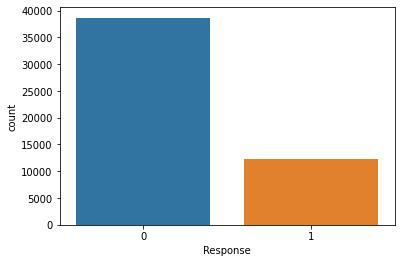

In [ ]:
sns.countplot(train['Response'])

In [390]:
y = train['Response']
X = train.drop(columns=['ID','Response'])
Xt = test.drop(columns='ID')

X = np.array(X)
Xt = np.array(Xt)
y = np.array(y)

X.shape,y.shape, Xt.shape

((50882, 79), (50882,), (21805, 79))

In [391]:
scaler = MinMaxScaler()                       # MInMaxScaler - Normalize the data
X      = scaler.fit_transform(X)
Xt = scaler.fit_transform(Xt) 

In [392]:
scaler = StandardScaler()                       # StandardScaler - 0 mean and unit variance
X  = scaler.fit_transform(X)
Xt = scaler.fit_transform(Xt) 

In [393]:
# KFold Cross Validation

from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
def _kfoldcv(model,X,y,Xt,nsplits,seed=10) :

  kf = StratifiedKFold(n_splits=nsplits,shuffle=True,random_state=seed)
  pred_test_full =0
  cv_score =[]
  i=1  

  for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X[train_index],X[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    #model
    clf = model
    clf.fit(xtr,ytr)
    score = roc_auc_score(yvl,clf.predict_proba(xvl)[:,1])
    print('ROC AUC score:',score)
    cv_score.append(score)    
    pred_test = clf.predict_proba(Xt)[:,1]
    pred_test_full +=pred_test
    i+=1

  print('CV mean score :', np.array(cv_score).mean())

  #proba = lr.predict_proba(xvl)[:,1]
  #frp,trp, threshold = roc_curve(yvl,proba)
  #roc_auc_ = auc(frp,trp)

  #plt.figure(figsize=(14,8))
  #plt.title('Reciever Operating Characteristics')
  #plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
  #plt.legend(loc='lower right')
  #plt.plot([0,1],[0,1],'b--')
  #plt.ylabel('True positive rate')
  #plt.xlabel('False positive rate')

  return pred_test

In [394]:
_kfoldcv(LogisticRegression(max_iter=1000),X,y,Xt,10,seed=10) 

1 of KFold 10
ROC AUC score: 0.5582191432760202
2 of KFold 10
ROC AUC score: 0.5814109681741533
3 of KFold 10
ROC AUC score: 0.5529985420516385
4 of KFold 10
ROC AUC score: 0.5661290742749238
5 of KFold 10
ROC AUC score: 0.571104710747845
6 of KFold 10
ROC AUC score: 0.5610511421217396
7 of KFold 10
ROC AUC score: 0.5531396408044973
8 of KFold 10
ROC AUC score: 0.5616261582126594
9 of KFold 10
ROC AUC score: 0.5627295960887893
10 of KFold 10
ROC AUC score: 0.5853452013265823
CV mean score : 0.5653754177078849


array([0.14089853, 0.24983877, 0.23800328, ..., 0.14182066, 0.24234412,
       0.15288102])

In [192]:
# With one-hot-encoder with scaling the continuos variables

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=40,shuffle =True,stratify =y)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((38161, 78), (38161,), (12721, 78), (12721,))

In [ ]:
train.Response.value_counts('Normalize')

0    0.760053
1    0.239947
Name: Response, dtype: float64

In [ ]:
X = train[['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator','Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium','Holding_Policy_Duration_YRS', 'Total_Policy_Cases',
       'Insurance_Cover_yrs', 'Total_Insurance_Payable']]
y = train['Response']

# Drop columns that have 40% NAN in the data

#X = train[['City_Code', 'Region_Code', 'Accomodation_Type',
#       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
#       'Health Indicator','Reco_Policy_Cat', 'Reco_Policy_Premium']]
#y = train['Response']

X , y = np.array(X),np.array(y)

In [ ]:
# New features added

X = train[['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium','Total_Premium_Payable']]
y = train['Response']

X , y = np.array(X),np.array(y)

In [ ]:
X_test = test[['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium','Holding_Policy_Duration_YRS', 'Total_Policy_Cases',
       'Insurance_Cover_yrs', 'Total_Insurance_Payable']]

# Drop columns that have 40% NAN in the data
#X_test = test[['City_Code', 'Region_Code', 'Accomodation_Type',
#       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
#       'Health Indicator', 'Reco_Policy_Cat', 'Reco_Policy_Premium']]

X_test = np.array(X_test)

In [ ]:
# New feature added

X_test = test[['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium','Total_Premium_Payable']]

X_test = np.array(X_test)

In [ ]:
y

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [206]:
scaler = MinMaxScaler()
X      = scaler.fit_transform(X)
Xt = scaler.fit_transform(Xt) 

In [ ]:
scaler = StandardScaler()
X      = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test) 

In [ ]:
X

array([[6.28571429e-01, 5.18650089e-01, 1.00000000e+00, ...,
        7.36842105e-02, 0.00000000e+00, 2.00921737e-01],
       [8.85714286e-01, 1.80203456e-01, 0.00000000e+00, ...,
        1.68421053e-01, 8.98305085e-01, 7.12739419e-01],
       [8.85714286e-01, 6.02454384e-01, 0.00000000e+00, ...,
        6.31578947e-02, 0.00000000e+00, 4.81774320e-03],
       ...,
       [0.00000000e+00, 7.12094300e-02, 1.00000000e+00, ...,
        2.00000000e-01, 0.00000000e+00, 1.96446944e-01],
       [0.00000000e+00, 4.84417891e-04, 0.00000000e+00, ...,
        7.57894737e-01, 3.72881356e-01, 6.22599937e-02],
       [6.28571429e-01, 6.24091716e-01, 1.00000000e+00, ...,
        2.10526316e-02, 0.00000000e+00, 2.29024847e-02]])

In [207]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=40,shuffle =True,stratify =y)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((38161, 78), (38161,), (12721, 78), (12721,))

In [210]:
lgclf = LogisticRegression(random_state=0,max_iter=1000).fit(X_train, y_train)
lgprd = lgclf.predict_proba(X_val)[:,1]
lgprdT = lgclf.predict_proba(Xt)[:,1]
lgprd

array([0.31196116, 0.17558785, 0.25817936, ..., 0.17695272, 0.26618781,
       0.33048856])

In [211]:
score = roc_auc_score(y_val,lgprd)
print(score)

0.5744151737043993


In [196]:
lgprdT

array([0.33407474, 0.1955493 , 0.33731175, ..., 0.19418532, 0.33203889,
       0.17981867])

In [212]:
def _ML_modelsPred(model,X_train,y_train,X_test) :

  clf = model.fit(X_train, y_train)
  mprd = clf.predict_proba(X_val)[:,1]
  mprdT = clf.predict_proba(Xt)[:,1]
  score = roc_auc_score(y_val,mprd,average='weighted')
  #crossval_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=10)
  print("ROC Score for training set :" ,score)
  #print("Crossval Score :",  crossval_scores.mean())
  return mprd,mprdT

In [213]:
# Decisiontree classifier

DTmprdT  = _ML_modelsPred(DecisionTreeClassifier(criterion='entropy',max_depth=5,
                                                 max_features ='auto',random_state =0),X_train,y_train,Xt)

ROC Score for training set : 0.5331604042699325


In [214]:
# Naive Bayes classifier

GNBmprdT  = _ML_modelsPred(GaussianNB(var_smoothing=1e-09),X_train,y_train,Xt)

ROC Score for training set : 0.5404289417463792


In [215]:
# Randomforest classifier

RFmprdT  = _ML_modelsPred(RandomForestClassifier(n_estimators=2000,max_depth =10,
                                                 random_state=0),X_train,y_train,Xt)

ROC Score for training set : 0.6035868844601662


In [216]:
# XGBoost classifier

XGBmprd,XGBmprdT  = _ML_modelsPred(xgb.XGBClassifier(n_estimators=2000,max_depth =10,
                                                 random_state=0),X_train,y_train,Xt)

ROC Score for training set : 0.6552946432553158


In [ ]:
#Perform random grid search for finding the best model
from time import *
def findbestparamfor(X,y) :
    reg = xgb.XGBClassifier("binary:logistic")

    param_grid = {
        'silent': [False],
        'max_depth': [3,4,5,6,8,10,12,15,20],
        'learning_rate': [0.001, 0.01, 0.1, 0.15,0.2,0.25, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0,0.1, 0.25,0.2,0.3,0.4, 0.5, 1.0],
        'alpha': [0,0.001,0.005,0.01,0.05],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
        ,'n_estimators': [200,500,1000,1500,2000]}

       
    rs_reg = RandomizedSearchCV(reg, param_grid,n_iter=4,
                            n_jobs=-1, verbose=2,                            
                            refit=False, cv =10,random_state=42)

    print("Randomized search..")
    search_time_start = time()
   # rs_reg.fit(X, y,early_stopping_rounds =50,eval_set=[(Xval,yval)])
    rs_reg.fit(X,y)
    print("Randomized search time:", time() - search_time_start)

    best_score = rs_reg.best_score_
    best_params = rs_reg.best_params_
    print("Best score: {}".format(best_score))
    print("Best params: ")
    for param_name in sorted(best_params.keys()):
        print('%s: %r' % (param_name, best_params[param_name]))


In [ ]:
findbestparamfor(X_train,y_train)

Randomized search..
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.9min


Randomized search time: 460.00454449653625
Best score: 0.7600429763899668
Best params: 
alpha: 0.001
colsample_bylevel: 0.8
colsample_bytree: 0.6
gamma: 0.1
learning_rate: 0
max_depth: 20
min_child_weight: 10.0
n_estimators: 1500
reg_lambda: 50.0
silent: False
subsample: 0.9


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.7min finished


In [ ]:
XGBmprd,XGBmprdT  = _ML_modelsPred(xgb.XGBClassifier(n_estimators=1500,max_depth =20,alpha=.001,colsample_bylevel=0.8,
                                                 colsample_bytree=0.6,gamma=0.1,learning_rate=0,
                                                 min_child_weight=10.0,reg_lambda=50.0,subsample=0.8,random_state=0),X_train,y_train,X_test)

ROC Score for training set : 0.5


1 of KFold 10
ROC AUC score: 0.6591529481912108
2 of KFold 10
ROC AUC score: 0.665776098557898
3 of KFold 10
ROC AUC score: 0.658054740875108
4 of KFold 10
ROC AUC score: 0.6556996378563485
5 of KFold 10
ROC AUC score: 0.6619316262450475
6 of KFold 10
ROC AUC score: 0.667569749028244
7 of KFold 10
ROC AUC score: 0.6556068728295259
8 of KFold 10
ROC AUC score: 0.6583097661452975
9 of KFold 10
ROC AUC score: 0.6568935110440154
10 of KFold 10
ROC AUC score: 0.6673177161928131
CV mean score : 0.6606312666965509


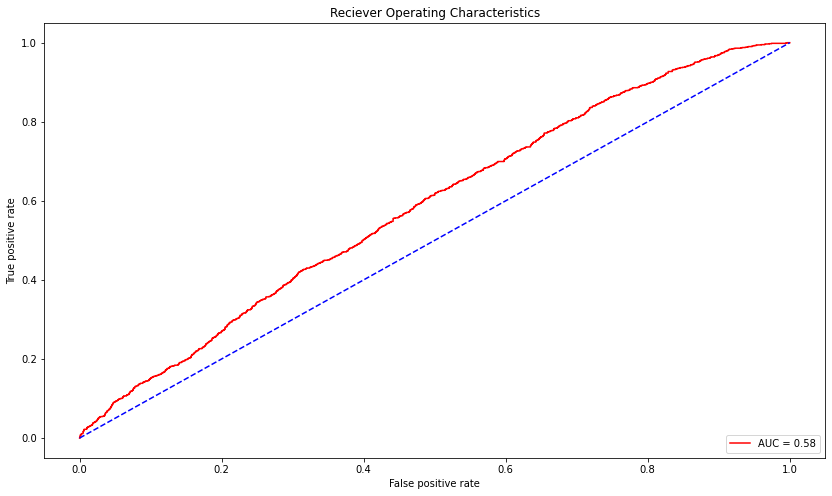

In [266]:
XGBmprdT = _kfoldcv(xgb.XGBClassifier(n_estimators=2000,max_depth =10,
                                                 random_state=0),X,y,Xt,10,seed=10) 

In [ ]:
XGBmprdT

array([0.05379714, 0.07840323, 0.19107716, ..., 0.00342841, 0.12067366,
       0.05581576], dtype=float32)

In [395]:
LGBmprdT = _kfoldcv(lgb.LGBMClassifier(n_estimators=2000),X,y,Xt,10,seed=10) 

1 of KFold 10
ROC AUC score: 0.6607646943737947
2 of KFold 10
ROC AUC score: 0.661226493956587
3 of KFold 10
ROC AUC score: 0.6418649448183499
4 of KFold 10
ROC AUC score: 0.6562863025236959
5 of KFold 10
ROC AUC score: 0.6601779860119659
6 of KFold 10
ROC AUC score: 0.6513000764358405
7 of KFold 10
ROC AUC score: 0.6500159797289355
8 of KFold 10
ROC AUC score: 0.6473253703664874
9 of KFold 10
ROC AUC score: 0.6506339896564878
10 of KFold 10
ROC AUC score: 0.6644534371454465
CV mean score : 0.654404927501759


In [ ]:
# LightGBM classifier

LGBmprd,LGBmprdT  =  _ML_modelsPred(lgb.LGBMClassifier(n_estimators=2000,subsample= 0.2, num_leaves =127, min_data_in_leaf =70,
                                      metric= 'auc_roc',max_depth=10,learning_rate = 0.05, feature_fraction = 0.6, 
                                      bagging_frequency = 6, bagging_fraction =0.9) ,X_train,y_train,X_test)



ROC Score for training set : 0.6560825852086771


In [217]:
# LightGBM classifier

LGBmprd,LGBmprdT  =  _ML_modelsPred(lgb.LGBMClassifier(n_estimators=2000) ,X_train,y_train,Xt)


ROC Score for training set : 0.6483725332083036


In [ ]:
# knn classifier

KnnmprdT  = _ML_modelsPred(KNeighborsClassifier(n_neighbors=7),X_train,y_train,X_test)


ROC Score for training set : 0.5372186340342398


In [396]:
CBmprdT = _kfoldcv(CatBoostClassifier(n_estimators=2000,verbose=0),X,y,Xt,10,seed=10) 

1 of KFold 10
ROC AUC score: 0.6770513344970429
2 of KFold 10
ROC AUC score: 0.6792493819381099
3 of KFold 10
ROC AUC score: 0.6651190092732298
4 of KFold 10
ROC AUC score: 0.6801078531101805
5 of KFold 10
ROC AUC score: 0.6729386837998165
6 of KFold 10
ROC AUC score: 0.6759870103547373
7 of KFold 10
ROC AUC score: 0.6668265698521711
8 of KFold 10
ROC AUC score: 0.6743843780306155
9 of KFold 10
ROC AUC score: 0.667128373877792
10 of KFold 10
ROC AUC score: 0.684405330642724
CV mean score : 0.674319792537642


In [262]:
CBmprdT

array([0.26890109, 0.19156291, 0.25013399, ..., 0.02995679, 0.19203923,
       0.14271167])

In [224]:
# CatBoostClassifier

CBmprd,CBmprdT  = _ML_modelsPred(CatBoostClassifier(n_estimators=2000),X_train,y_train,Xt)

Learning rate set to 0.025837
0:	learn: 0.6846241	total: 19.7ms	remaining: 39.3s
1:	learn: 0.6768837	total: 31.8ms	remaining: 31.8s
2:	learn: 0.6695199	total: 50.1ms	remaining: 33.3s
3:	learn: 0.6624627	total: 69.4ms	remaining: 34.6s
4:	learn: 0.6560557	total: 88.6ms	remaining: 35.4s
5:	learn: 0.6497440	total: 107ms	remaining: 35.5s
6:	learn: 0.6427833	total: 125ms	remaining: 35.5s
7:	learn: 0.6370677	total: 143ms	remaining: 35.7s
8:	learn: 0.6316643	total: 162ms	remaining: 35.8s
9:	learn: 0.6267241	total: 180ms	remaining: 35.7s
10:	learn: 0.6220804	total: 201ms	remaining: 36.3s
11:	learn: 0.6176585	total: 219ms	remaining: 36.3s
12:	learn: 0.6135481	total: 249ms	remaining: 38.1s
13:	learn: 0.6097442	total: 268ms	remaining: 38s
14:	learn: 0.6058985	total: 286ms	remaining: 37.9s
15:	learn: 0.6020943	total: 305ms	remaining: 37.8s
16:	learn: 0.5986226	total: 324ms	remaining: 37.8s
17:	learn: 0.5954894	total: 343ms	remaining: 37.8s
18:	learn: 0.5925348	total: 362ms	remaining: 37.8s
19:	lear

In [ ]:
CBmprdT

array([0.30128616, 0.24019159, 0.27876093, ..., 0.02013416, 0.20897753,
       0.17258378])

In [263]:
subm.head()

,ID,Response
0,50883,0
1,50884,0
2,50885,0
3,50886,0
4,50887,0


In [ ]:
id = np.array(test['ID'])
id

array([50883, 50884, 50885, ..., 72685, 72686, 72687], dtype=int64)

In [ ]:
subDF = pd.DataFrame({'ID' : id,'Response' :lgprdT })
subDF

,ID,Response
0,50883,0.156747
1,50884,0.232679
2,50885,0.249267
3,50886,0.260792
4,50887,0.163089
...,...,...
21800,72683,0.245424
21801,72684,0.254321
21802,72685,0.143571
21803,72686,0.253649


In [264]:
def _subModelP(modelprediction,modelname) :
  id = np.array(test['ID'])
  subDF = pd.DataFrame({'ID' : id,'Response' :modelprediction })
  subDF.to_csv(modelname,index=False)

In [ ]:
subDF.to_csv('LogPred03.csv',index=False)

In [ ]:
_subModelP(DTmprdT ,'DTreePred01.csv')

In [ ]:
_subModelP(GNBmprdT,'GNBPred01.csv')

In [ ]:
_subModelP(RFmprdT,'RFPred01.csv')

In [269]:
_subModelP(XGBmprdT,'XGBPred02.csv')

In [ ]:
_subModelP(LGBmprdT,'LGBMPred02.csv')

In [320]:
_subModelP(CBmprdT,'CBMPred08.csv')

In [ ]:
# hyper parameter tunning for LightGBM

SEED = 4 
NFOLDS = 2
kf = KFold(n_splits= NFOLDS, shuffle=False)

parameters = {
          'num_leaves': np.arange(100,500,100),
          'min_child_weight': np.arange(0.01,1,0.01),
    }

model = lgb.LGBMClassifier()

RSCV = RandomizedSearchCV(model,parameters,scoring='roc_auc',cv=kf.split(X_train),n_iter=30,verbose=50)
RSCV.fit(X_train,y_train)

parameters = {
          'feature_fraction': np.arange(0.1,0.4,0.01),
          'bagging_fraction':np.arange(0.3,0.5,0.01),
          'min_data_in_leaf': np.arange(100,1500,10),
    }

RSCV = RandomizedSearchCV(RSCV.best_estimator_,parameters,scoring='roc_auc',cv=kf.split(X_train),n_iter=30,verbose=50)
RSCV.fit(X_train,y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] num_leaves=400, min_child_weight=0.9 ............................
[CV]  num_leaves=400, min_child_weight=0.9, score=0.632, total=   2.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[CV] num_leaves=400, min_child_weight=0.9 ............................
[CV]  num_leaves=400, min_child_weight=0.9, score=0.635, total=   2.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[CV] num_leaves=400, min_child_weight=0.54 ...........................
[CV]  num_leaves=400, min_child_weight=0.54, score=0.636, total=   2.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s
[CV] num_leaves=400, min_child_weight=0.54 ...........................
[CV]  num_leaves=400, min_child_weight=0.54, score=0.633, total=   2.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elap

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f1bdd136d50>,
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.52,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=100, objective=None,
                                            ran...
        980,  990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080,
       1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190,
   

In [ ]:
LGBmprdT = RSCV.predict_proba(X_test)[:,1]

In [ ]:
# Hyperparameter tunning for LGBM using randomizedsearch

rs_params = {

        'bagging_fraction': [0.5,0.6,0.7,0.8,0.9],
        'learning_rate'   : [0.1,0.01,0.3,0.03,0.5,0.05,0.9],
        'bagging_frequency': [5,6,7,8,9],
        'subsample'        : [0.2,0.3,0,4],
        'feature_fraction': [0.5,0.6,0,7,0.8,0.9],
        'max_depth': [2,6,8,10,15],
        'min_data_in_leaf': [10,30,50,70,90,120],
        'num_leaves': [15, 31, 63, 127,500,1000,2000],
        'metric'    : ['auc_roc']

}



# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv = RandomizedSearchCV(estimator=lgb.LGBMClassifier(type= 'GPU',subsample_for_bin=200000,
    min_child_samples =20,
    min_child_weight = 0.001,
    min_split_gain = 0.0,
    colsample_bytree = 1.0,
    reg_alpha = 0.0,
    reg_lambda = 0.0,njobs=-1), param_distributions=rs_params, cv = 10, n_iter= 100,verbose=True)

# Train on training data-
rs_cv.fit(X_train, y_train,verbose=False)
print("BEST PARAMETERS: " + str(rs_cv.best_params_))
print("BEST CV SCORE: " + str(rs_cv.best_score_))

pred = rs_cv.predict_proba(X_test)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: feature_fraction <=1.0 at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 303 .


  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: feature_fraction <=1.0 at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 303 .


  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these par

BEST PARAMETERS: {'subsample': 0.2, 'num_leaves': 31, 'min_data_in_leaf': 30, 'metric': 'auc_roc', 'max_depth': 10, 'learning_rate': 0.1, 'feature_fraction': 0.9, 'bagging_frequency': 9, 'bagging_fraction': 0.7}
BEST CV SCORE: 0.760645681160471


In [ ]:
LGBmprdT = pred[:,1]

In [ ]:
LGBmprdT

array([0.22257679, 0.26712223, 0.2768633 , ..., 0.00700645, 0.2422085 ,
       0.13940995])

In [ ]:
_subModelP(LGBmprdT,'LGBMPred03.csv')

In [397]:
# Model Blending LGBM /XGB / CATBOOST simple AVG

df1 = pd.DataFrame({'XGB' : XGBmprdT})
df2 = pd.DataFrame({'LGB' : LGBmprdT})
df3 = pd.DataFrame({'CB'  : CBmprdT})          

df = pd.concat([df1,df2,df3],axis=1)

#df['FinalP'] = (df.XGB + df.LGB + df.CB) / 3

df['FinalP'] = (df.LGB + df.CB) /2

df

,XGB,LGB,CB,FinalP
0,0.013616,0.070058,0.248393,0.159226
1,0.354282,0.301469,0.193089,0.247279
2,0.320279,0.188668,0.232929,0.210798
3,0.206981,0.348133,0.247608,0.297871
4,0.008384,0.181622,0.178879,0.180250
...,...,...,...,...
21800,0.151095,0.298114,0.208410,0.253262
21801,0.071749,0.254196,0.237576,0.245886
21802,0.000688,0.001554,0.030537,0.016045
21803,0.186505,0.196095,0.195283,0.195689


In [ ]:
# Model Blending LGBM /XGB / CATBOOST Weighted AVG

df1 = pd.DataFrame({'XGB' : XGBmprdT})
df2 = pd.DataFrame({'LGB' : LGBmprdT})
df3 = pd.DataFrame({'CB'  : CBmprdT})          

df = pd.concat([df1,df2,df3],axis=1)

df['FinalP'] = (2* df.XGB + df.LGB + 2* df.CB) / 5

df

,XGB,LGB,CB,FinalP
0,0.053797,0.081356,0.301286,0.158304
1,0.078403,0.269415,0.240192,0.181321
2,0.191077,0.328643,0.278761,0.253664
3,0.250380,0.158678,0.223630,0.221340
4,0.040310,0.117353,0.274096,0.149233
...,...,...,...,...
21800,0.048434,0.186074,0.210653,0.140849
21801,0.156738,0.124498,0.231980,0.180387
21802,0.003428,0.004359,0.020134,0.010297
21803,0.120674,0.197380,0.208978,0.171336


In [267]:
# Model Blending LGBM /XGB / CATBOOST RANK AVG

df1 = pd.DataFrame({'XGB' : XGBmprdT})
df2 = pd.DataFrame({'LGB' : LGBmprdT})
df3 = pd.DataFrame({'CB'  : CBmprdT})     

# Rank of 1 for least model pred and 3 for best model pred

r1_Weight ,r2_Weight , r3_Weight  = 1/3 , 1/3 , 2/3

df = pd.concat([df1,df2,df3],axis=1)

df['FinalP'] = (r1_Weight * df.XGB + r2_Weight * df.LGB + r3_Weight * df.CB) 

df

,XGB,LGB,CB,FinalP
0,0.013616,0.048032,0.268901,0.199817
1,0.354282,0.142861,0.191563,0.293423
2,0.320279,0.351823,0.250134,0.390790
3,0.206981,0.241989,0.235848,0.306889
4,0.008384,0.122111,0.210349,0.183731
...,...,...,...,...
21800,0.151095,0.174334,0.234685,0.264933
21801,0.071749,0.137278,0.227372,0.221257
21802,0.000688,0.003253,0.029957,0.021285
21803,0.186505,0.444215,0.192039,0.338266


In [ ]:
# Model Blending LGBM /XGB / CATBOOST simple AVG

df1 = pd.DataFrame({'XGB' : XGBmprd})
df2 = pd.DataFrame({'LGB' : LGBmprd})
df3 = pd.DataFrame({'CB'  : CBmprd})          

df = pd.concat([df1,df2,df3],axis=1)

df

,XGB,LGB,CB
0,0.559456,0.299432,0.391467
1,0.008518,0.070852,0.294144
2,0.379374,0.192002,0.233264
3,0.549848,0.217681,0.289944
4,0.885626,0.687662,0.359679
...,...,...,...
15260,0.003032,0.000084,0.010704
15261,0.078518,0.239246,0.277175
15262,0.005031,0.118514,0.232573
15263,0.011684,0.022522,0.068598


In [ ]:
# Build another model on top of blended models XGB,CB,LGB

X = np.array(df[['XGB','LGB','CB']])
lrclf = LogisticRegression(max_iter=1000)
lrclf.fit(X,y_val)
lrclf.predict_proba(X)[:,1]


array([0.453275  , 0.2541234 , 0.25465617, ..., 0.20197737, 0.10545116,
       0.2367807 ])

In [ ]:
X = np.array(df[['XGB','LGB','CB']])
cbclf = CatBoostClassifier(n_estimators=2000)
cbclf.fit(X,y_val)
CBmprdT = cbclf.predict_proba(X_test)[:,1]

Learning rate set to 0.017471
0:	learn: 0.6856333	total: 8.74ms	remaining: 17.5s
1:	learn: 0.6786111	total: 17.6ms	remaining: 17.6s
2:	learn: 0.6717704	total: 29.8ms	remaining: 19.8s
3:	learn: 0.6653952	total: 38.5ms	remaining: 19.2s
4:	learn: 0.6590775	total: 48.5ms	remaining: 19.4s
5:	learn: 0.6532745	total: 57.4ms	remaining: 19.1s
6:	learn: 0.6477706	total: 67.4ms	remaining: 19.2s
7:	learn: 0.6425530	total: 75ms	remaining: 18.7s
8:	learn: 0.6372990	total: 83.8ms	remaining: 18.5s
9:	learn: 0.6319773	total: 93.6ms	remaining: 18.6s
10:	learn: 0.6274748	total: 102ms	remaining: 18.4s
11:	learn: 0.6231392	total: 110ms	remaining: 18.3s
12:	learn: 0.6186955	total: 121ms	remaining: 18.5s
13:	learn: 0.6146871	total: 131ms	remaining: 18.5s
14:	learn: 0.6107073	total: 140ms	remaining: 18.5s
15:	learn: 0.6068923	total: 152ms	remaining: 18.9s
16:	learn: 0.6032842	total: 161ms	remaining: 18.8s
17:	learn: 0.5995334	total: 171ms	remaining: 18.8s
18:	learn: 0.5961662	total: 179ms	remaining: 18.7s
19:

In [398]:
_subModelP(df.FinalP,'MBlendSAvg07.csv')

In [ ]:
_subModelP(CBmprdT,'MBlend-CB.csv')